<p><img alt="Colaboratory logo" height="65px" src="https://upload.wikimedia.org/wikipedia/en/thumb/b/b1/Davivienda_logo.svg/1200px-Davivienda_logo.svg.png" align="left" hspace="10px" width="20%" vspace="15px"></p>

<h1 align="center"> Prueba Técnica Profesional III Departamento de Datos no Estructurados  </h1>
 <h2 align = "center"> Autor: Andres Ochoa Arango </h2> 

### **Objetivo del modelo** 

El objetivo de esta prueba es desarrollar una analítica preliminar sobre un conjunto de tweets en los que se menciona de una u otra forma a nuestra organización. Mediante herramientas de procesamiento de lenguaje natural (NLP) buscamos que desarrollen el procesamiento de los textos contenidos en los tweets, que encuentren insights que puedan ser de interés para áreas como
marketing, servicio al cliente, etc; y que visualicen estos datos de una forma clara para tomadores de decisiones. Además, en la medida de lo posible, buscamos una agrupación de estos tweets, en las categorías que ustedes consideren las mejores para hacer una buena analítica descriptiva de lo que opinan nuestros clientes en Twitter

#### Source de la información: 

```
!wget "https://raw.githubusercontent.com/yemoncada/davivienda_tweets/main/davivienda_tweets.csv" -P "/content"
```

Este archivo contiene un conjunto de **tweets extraidos de la red social** de Twitter que contienen la palabra **Davivienda** y con el cual quisieramos conocer cual es la interacción que tienen los diferentes usuarios de la red social con el Banco Davivienda. Todo esto a partir de una exploración general de lo que esta en los textos, cabe destacar que este notebook esta diseñado para que realice una exploración guiada y que por medio de esta vaya realizando sus propios descubrimientos e insights sobre la base de datos.

#### Modelo propuesto

Por último y con la finalidad de obtener un analisis más detallado, realice un modelo no supervisado Latent Dirichlet Allocation (LDA) que permita conocer por topicos, cuales son los temas más hablados en Twitter asociados a la palabra Davivienda.

<p><img alt="Colaboratory logo" src="https://i.ibb.co/3zNV9vX/1-Gp-PEknl-KMQ09-Uk-Et-Y6-MZOw.png" align="left" hspace="10px" vspace="15px"></p>

#### Diseño del Notebook 

Se realiza una pequeña explicación en cada apartado y luego se expresa con más detalle las conclusiones obtenidas en la parte final.

In [27]:
#Librerias utilizadas
import pandas as pd
import numpy as np
try:
    import re # Libreria para manipular strings
except: 
    !pip install re
try: 
    import nltk # Libreria para aplicar modelos de NLP
    from nltk.corpus import stopwords
    nltk.download('stopwords')
except: 
    !pip install nltk
try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib

try:
    from sklearn.decomposition import  LatentDirichletAllocation
    from sklearn.feature_extraction.text import CountVectorizer
except: 
    !pip install sklearn
try: 
    import spacy # Paquete para aplicar modelos entrenados de NLP
except: 
    !pip install spacy
try:
    import es_core_news_sm # Modelo de spacy para español entrenado con noticas
except: 
    !pip install es_core_news_sm
try: 
    import spacy_spanish_lemmatizer
except: 
    !pip install spacy_spanish_lemmatizer
try: 
    from sentiment_analysis_spanish import sentiment_analysis #Modelo de Deep Learning para clasificacion de sentimientos
except: 
    !pip install sentiment_analysis_spanish 
try: 
    import warnings
    warnings.filterwarnings("ignore")
except: 
    !pip install warnings
try: 
    from wordcloud import WordCloud #Liberia para realizar las nubes de palabras
except: 
    !pip install wordcloud 
try: 
    import seaborn as sns
except: 
    !pip install seaborn
try: 
    import spacy_spanish_lemmatizer
except: 
    !pip install spacy_spanish_lemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrador\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Librerias utilizadas
dta = pd.read_csv('./davivienda_tweets.csv', sep = ',')

## Creacion de las funciones de limpieza

In [11]:
data = dta.copy()
def remove_URL(text):
    return re.sub(r"https?://\S+|www\.\S+", "", text)
def remove_html(text):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)
def remove_emojis(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
def Normalizar(texto):
    texto = texto.lower()
    # tildes y diacríticas
    # texto = re.sub('á', 'a', texto)
    # texto = re.sub('é', 'e', texto)
    # texto = re.sub('í', 'i', texto)
    # texto = re.sub('ó', 'o', texto)
    # texto = re.sub('ú', 'u', texto)
    # texto = re.sub('ü', 'u', texto)
    # texto = re.sub('ñ', 'n', texto)
    return texto
def Clean(texto):
    puntuación = r'[,;.:¡!¿?@#$%&[\](){}<>~=+\-*/|\\_^`"\']'
    
    # Se remuven los signos de puntuacion
    texto = re.sub(puntuación, ' ', texto)
    # Se remuven los numeros [0-9]
    texto = re.sub('\d', ' ', texto)
    return texto
def Menos_4(x):
    if len(x) <= 4:
        x = ''
    return x

#Pasis a seguir: Averiguar el modelo que se plantea en le problema y averiguar los modelos pertinentes para realizar el trabajo.
def Limpieza(columna, columna2): 
    data[columna] = str()
    data[columna] = data[columna2].apply(lambda x: Normalizar(x))
    data[columna] = data[columna].apply(lambda x: Clean(x))
    data[columna] = data[columna].apply(lambda x: remove_URL(x))
    data[columna] = data[columna].apply(lambda x: remove_html(x))
    data[columna] = data[columna].apply(lambda x: Menos_4(x))
    # En estsa parte se realiza el primer paso de la vectorización
    data[columna] = data[columna].apply(lambda x: x.split())
    data['txt_graph']=data[columna].apply(lambda x: ''.join(i+' ' for i in x)) # Se realiza para tener un analisis exploratorio


## 1. Análisis Exploratorio

En la base de datos se encuentra la información de 1811 tweets donde se menciona a la entidad @Davivienda. Hay 11 columnas, en donde se encuentra información relaciona al contenido del tweet. La persona que lo hizo, el contendió, emojis, enlaces, entre otras cosas. 

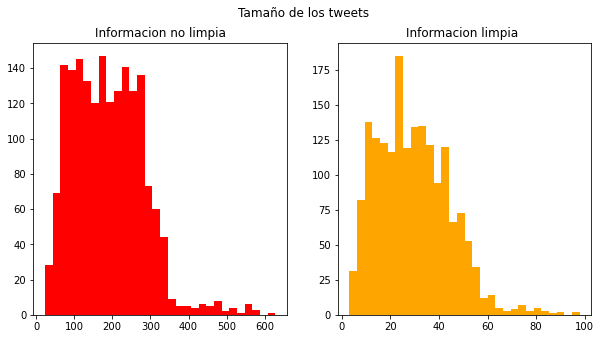

In [12]:
'''Limpieza de la informacion para comparar los tweets limpios o no'''
Limpieza('txt','Embedded_text')

'''Grafico: Histograma de la longitud de los tweets'''
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=data['Embedded_text'].str.len()
ax1.hist(tweet_len,color='red', bins = 30)
ax1.set_title('Informacion no limpia')
tweet_len= data['txt'].str.len()
ax2.hist(tweet_len,color='orange',  bins = 30)
ax2.set_title('Informacion limpia ')
fig.suptitle('Tamaño de los tweets')
plt.show()


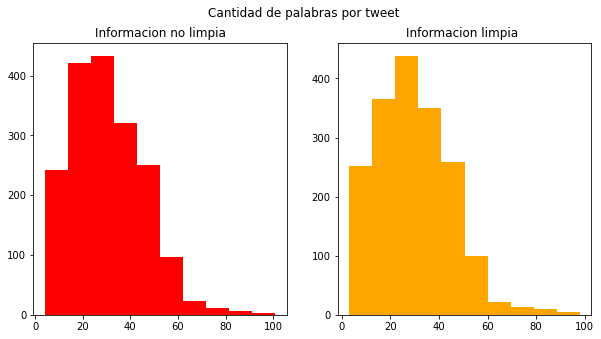

In [35]:
'''Grafico: Histograma con la cantidad de palabras por tweet'''
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=data['Embedded_text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('Informacion no limpia')
tweet_len= data['txt_graph'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='orange')
ax2.set_title('Informacion limpia ')
fig.suptitle('Cantidad de palabras por tweet')
plt.show()


Text(0.5, 0.98, 'Promedio del tamaño de las palabras por cada tweet')

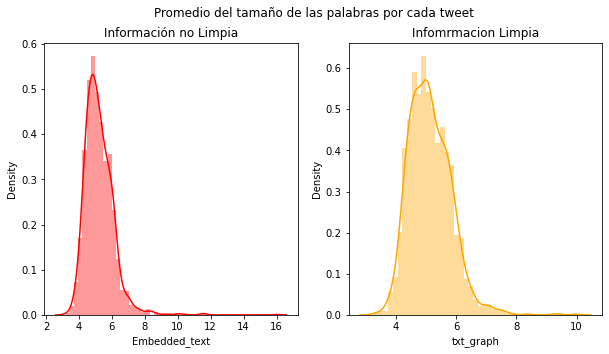

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=data['Embedded_text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Información no Limpia')
word=data['txt_graph'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='orange')
ax2.set_title('Infomrmacion Limpia')
fig.suptitle('Promedio del tamaño de las palabras por cada tweet')

## 2. Prepocesamiento de Texto

Para el preprocesamiento de la información, se inicia con la limpieza. En este caso, se eliminan todas las palabras que no contienen información para el análisis. Allí entra las stopswords, las palabras cortas, entre otras cosas que son explicado en las funciones de limpieza presentadas arriba.  Además, se opta por realizar un proceso de transformación llamado lematización. Esto con la finalidad de agrupar la información en definiciones comunes. En este apartado se presentan problemas que son explicado con mas detalle en la parte final. 


In [24]:
stop_words = set(stopwords.words('spanish')).union(['mas', 'si', 'sr', 'dia', 'asi', 'ir', 'tú', 'tu', 
                                                    'él','wilsonariasc', 'bancolombio', 'dar', 'él', 'yousexonfirir', 'www', 
                                                    'https', 'woooowwww', 'wooooow', 'días', 'hacer', 'lugar', 'equivocado', 'favor',
                                                    'banco', 'dice', 'puede', 'buenos', 'gusto', 'queremos', 'conocer', 'buenas', 
                                                    'tardes', 'solo', 'q', 'ustedes', 'atentos', 'davivienda', 'quedamos', 'privado', 'bancos',
                                                    'así', 'hola', 'hace', 'mismo', 'saludos', 'volvieron','marianiniecheve', 'com', 'watch',
                                                    'mensaje', 'sra', 'noches'])
for i in range(data.shape[0]):
    filtered_sentence = [w for w in data.at[i,'txt'] if not w in stop_words] 
    data.at[i, 'txt'] = filtered_sentence

In [25]:
# Proceso de lematizacíon: 
# La ejecución de esta celda puede ser demorada!
'''Por problemas que me encontre mas adelante, decidí separa la información 
para poder realizar una comparativa con la informacion con y sin lema'''
nlp = es_core_news_sm.load()
# nlp = spacy.load("es")
print("spaCy version: ", spacy.__version__)

data['txt_lema'] = str()
for j in range(data.shape[0]):
    oracion = []
    clean_tokens = data.at[j, 'txt']
    for i in range(len(clean_tokens)):
        if clean_tokens[i] in ['davivienda', 'Davivienda', 'DAVIVIENDA']:
            oracion.append(clean_tokens[i])
            pass
        else:
            palabra = nlp(clean_tokens[i])
            for word in palabra:
                lemmas=word.lemma_
                oracion.append(lemmas) 
    data.at[j,'txt_lema'] = oracion
print('Listo!')


spaCy version:  3.4.1
Listo!


In [26]:
#Vectorización y preparacion de los datos para el modelo "Matriz termino-documento - Document-Term Matrix"
data['final_txt']=data['txt_lema'].apply(lambda x: ''.join(i+' ' for i in x))
data['final_txt_sin_lema']=data['txt'].apply(lambda x: ''.join(i+' ' for i in x))
vectorizer = CountVectorizer(analyzer='word', ngram_range = (1,1))
x_tr = vectorizer.fit_transform(data['final_txt_sin_lema'].values)
columns= vectorizer.get_feature_names()
data_CV = x_tr.toarray()
data_sk = pd.DataFrame(data_CV, columns = columns, dtype = np.int8)

## 3. WordClouds con analisis de sentimiento

Intentando dar soluciones extras por si el primer modelo no funciona de la manera esperada. Se segmenta los tweets en el sentimiento que expresan, para poder lograr una imagen mas detallada de los mensajes hechos en la plataforma. Para este caso, se utiliza una red neuronal convolucional ya entrenada.

In [28]:
sentiment = sentiment_analysis.SentimentAnalysisSpanish()
'''
    Funcion para el analisis de sentimiento: 
    El modelo se obtiene del proyecto https://pypi.org/project/sentiment-analysis-spanish/
    Allí, se encuentra una red nuronal convolucional, entrenada con diferentes datos 
    de paginas web en español. En terminos generales, el modelo tiene un accuracy del 
    88% (Esto planteado por las personas del proyecto)'''

data['sentimiento'] = data['Embedded_text'].apply(lambda x: round(sentiment.sentiment(x), 1))
data['sentimiento_NLP'] = data['final_txt_sin_lema'].apply(lambda x: round(sentiment.sentiment(x), 1))
# print(sentiment.sentiment(data.at[121, 'Embedded_text']))


def Clasificador_sentimientos(x): 
    '''En esta función se busca clasificar los tweets en positivos, negativos y neutros.
    La finalidad es poder entregar que palabras son mas usadas para los 3 tipos de mensajes, 
    y saber que temas son los mas relevantes para cada tipo.'''
    respuesta = int()
    if x <=1 and x >= 0.5: 
        respuesta = 1
    elif x < 0.5 and x >= 0.2:
        respuesta = 0
    else: 
        respuesta = -1
    return respuesta


data['Clasificador_sentimiento'] = data['sentimiento'].apply(lambda x: round(Clasificador_sentimientos(x), 1))
data['Clasificador_sentimiento_NLP'] = data['sentimiento_NLP'].apply(lambda x: round(Clasificador_sentimientos(x), 1))

In [29]:
data_davivienda = data[data['UserScreenName'] == 'Banco Davivienda']
data_pos = data[data.Clasificador_sentimiento_NLP == 1]
data_neg = data[data.Clasificador_sentimiento_NLP == -1]
data_neu = data[data.Clasificador_sentimiento_NLP == 0]

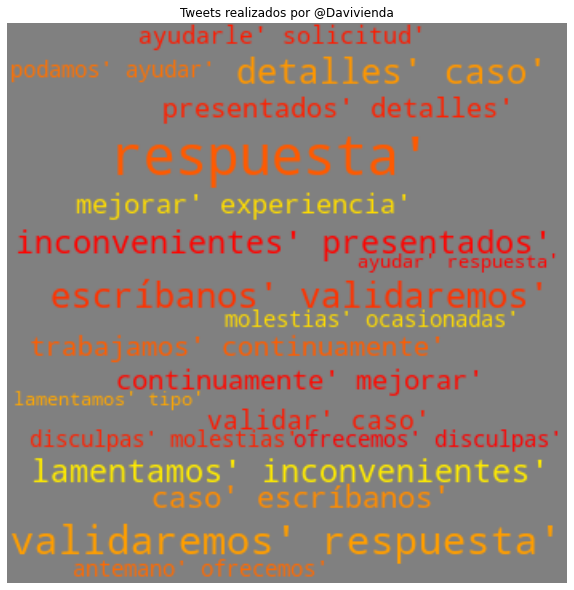

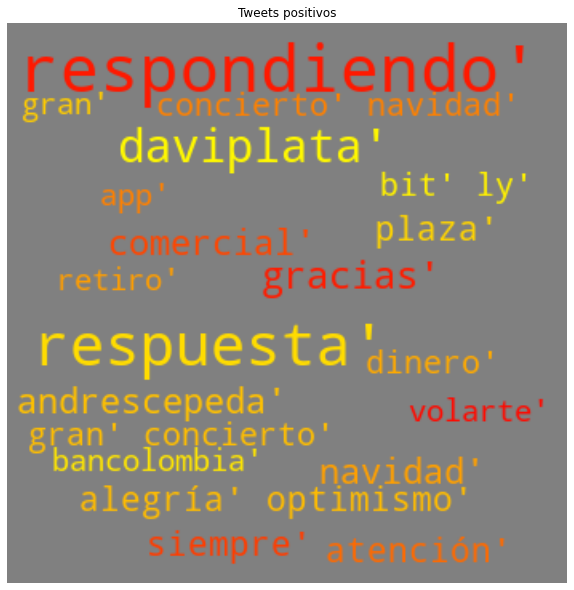

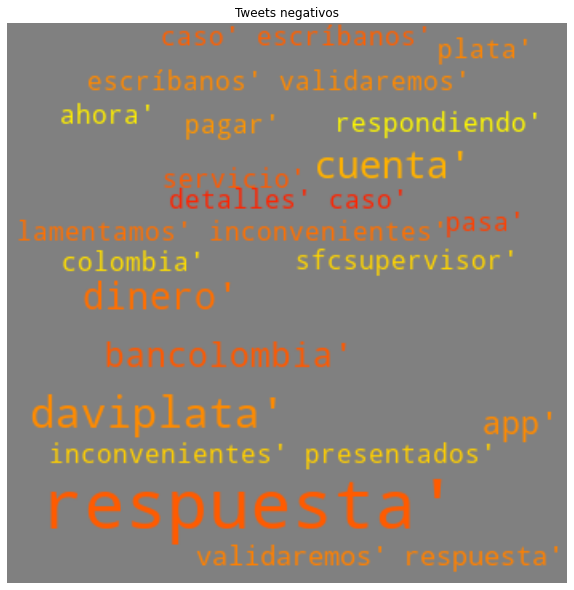

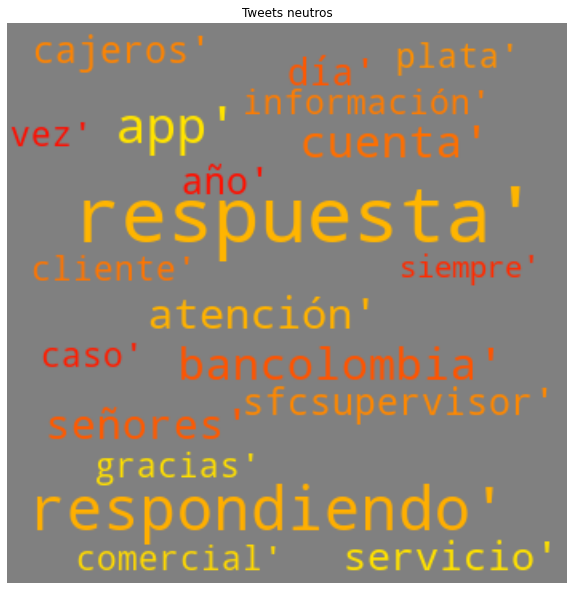

In [30]:
def Words_cloud(df, title = 'No title'):  
    comment_words = ''
    for val in df.txt:
         
        # typecaste each val to string
        val = str(val)
     
        # split the value
        tokens = val.split()
         
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
         
        comment_words += " ".join(tokens)+" "
     
    wordcloud = WordCloud(width = 350, height = 350,
                    background_color ='gray',
                    stopwords = stop_words,
                    min_font_size = 10, 
                    max_words=20,
                    prefer_horizontal = 1, 
                    colormap = 'autumn').generate(comment_words)
     
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.title(title)
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
Words_cloud(data_davivienda, 'Tweets realizados por @Davivienda')
Words_cloud(data_pos, 'Tweets positivos')
Words_cloud(data_neg, 'Tweets negativos')
Words_cloud(data_neu, 'Tweets neutros')


## 4. Latent Dirichlet Allocation - Modelo no supervisado de Tópicos.

El topic modeling es una técnica no supervisada de NLP, capaz de detectar y extraer de manera automática relaciones semánticas latentes de grandes volúmenes de información.

Estas relaciones son los llamados tópicos, que son un conjunto de palabras que suelen aparecer juntas en los mismos contextos y nos permiten observar relaciones que seríamos incapaces de observar a simple vista.

In [33]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 2, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

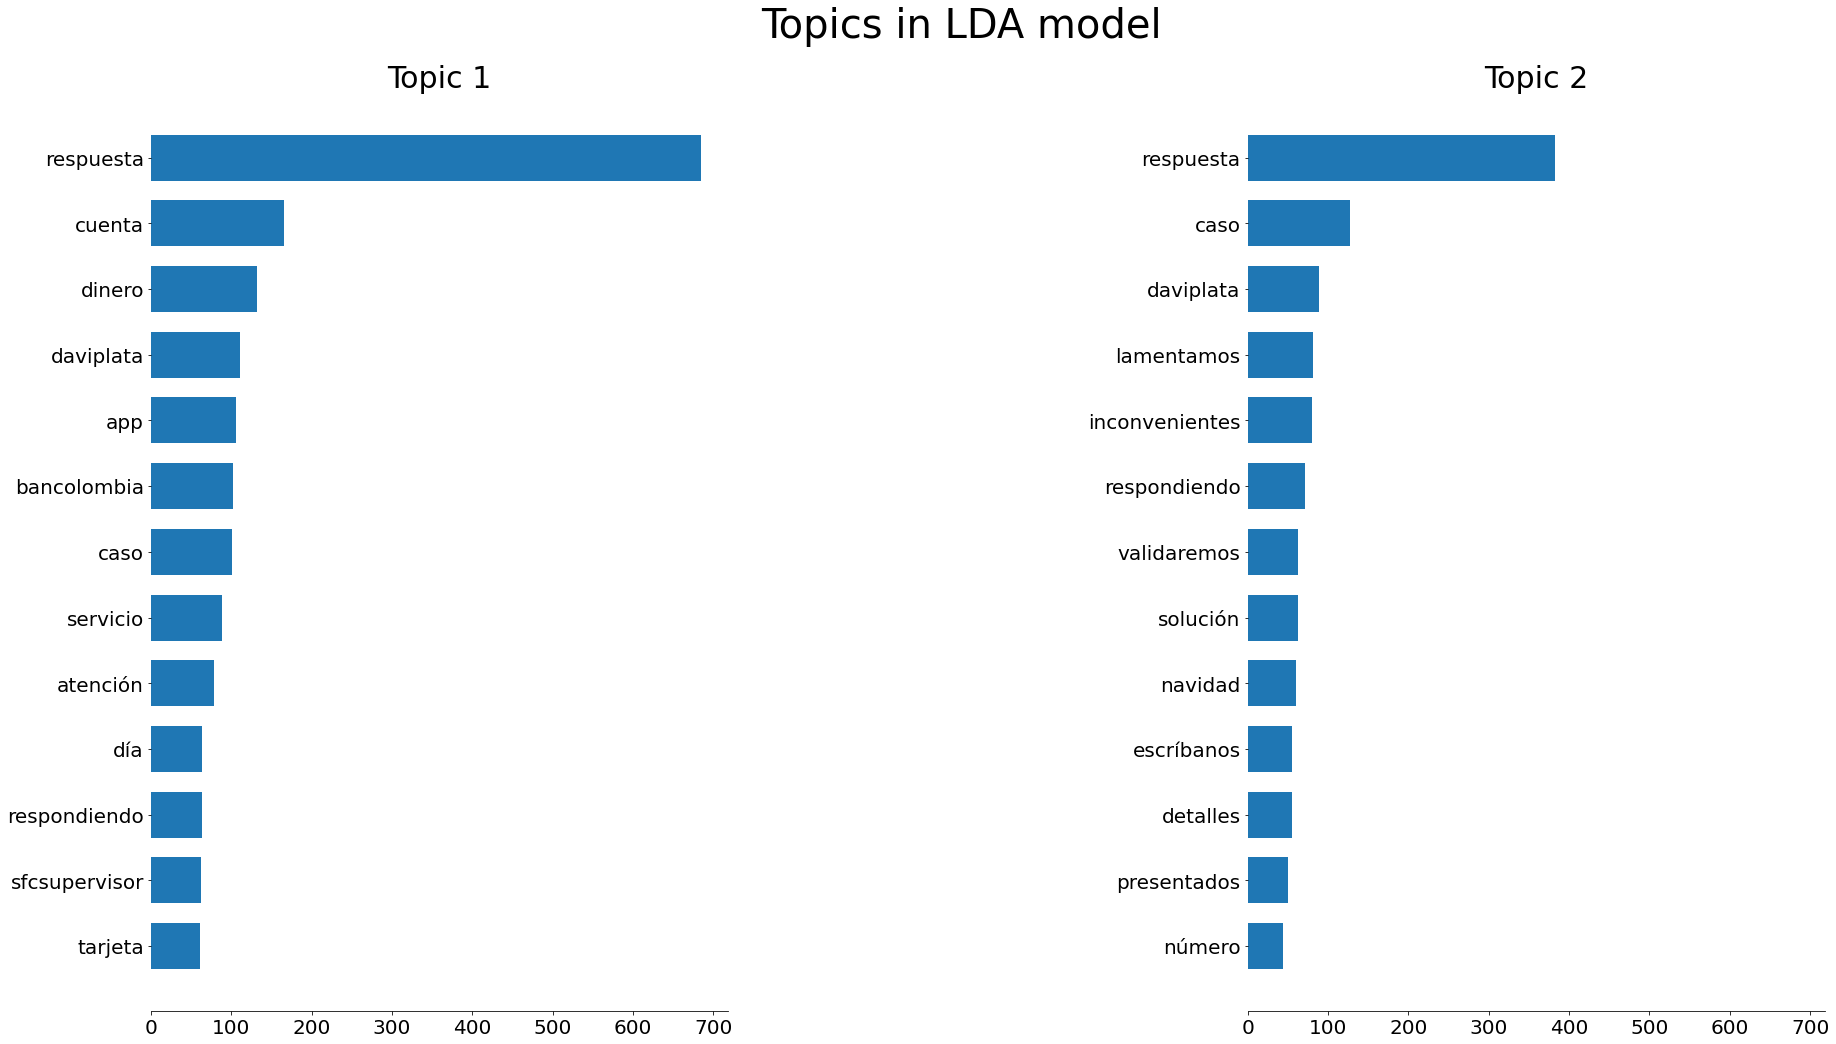

In [34]:
n_top_words = 13
# Documentación del modelo https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
lda = LatentDirichletAllocation(
    n_components=2,
    max_iter=13,
    learning_method="batch",
    learning_offset=50.0,
    random_state=42)

lda.fit(x_tr)


tf_feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

## 5. Interpretación de Resultados y conclusiones generales.

## Información relevante encontrada

**En el primer análisis** realizado con la información de las nubes de las palabras separadas por la red neuronal del análisis de sentimiento, se puede interpretar el tipo de mensaje que transmiten según cada tipo. Para el caso de la información que representa tweets “negativos” se resalta las palabras de respuesta hacia posibles quejas que los usuarios han tenido con algún servicio prestado por la entidad (Davivienda). Adicionalmente, se muestra que Twitter es un canal donde la entidad intenta validar y dar solución a los problemas que se presentan. Para este caso, se puede proponer un análisis de la cantidad de tweets negativos se producen y encontrar puntos de mejora para la entidad. 

Para el caso de los tweets neutros no se presenta información que ha primera vista sea relevante. Se puede deducir que algunos de estos tweets pueden ser categorizados de mala manera, lo cual los puntos de corte pueden ser revisados.
Los tweets positivos muestran la publicidad y posibles tweets de eventos, donde la entidad haya tenido una relación directa o indirecta. Para este caso se puede utilizar la información en conjunto con el área de marketing para llevar a cabo campañas de publicidad.

En los tres siempre resalta la palabra respuesta y atención. Con esto se supone que esta herramienta se utiliza como modo de comunicación con los clientes. Lo siguiente puede ser evaluar la eficacia en la solución de problemas mediante este medio de comunicación. 

**En el segundo análisis** se utiliza la información obtenida de un modelo no supervisado de machine learning llamado Latent Dirichlet Allocation. En este caso, no se encontró información tan contundente. Llevando a cabo diferentes pruebas, la cantidad de tópicos que reflejaban información coherente eran 2. Como se mencionó en el primer análisis, la palabra respuesta es protagonista en ambos tópicos, lo que puede indicar la interpretación presentada arriba. Para ambos tópicos se presentan palabras que representan posibles problemas con algún bien o un servicio otorgado por la entidad. Mas allá de este primer análisis, se debe realizar una serie de suposiciones que pueden llevar a malas interpretaciones. 


## Problemas presentados

Se presentaron problemas en la utilización de algoritmos para la transformación del texto. Para este caso, la aplicación de estos en el idioma español un limitado. Esto puede causar malos manejos de la información y malos análisis en el futuro. Por ende, ese tema personalmente es el mas crucial para llevar a cabo de manera correcta este tipo de análisis. 

El otro problema fue con la aplicación de LDA. En este caso, no encontré información contundente para separar la información contenida en 2 tópicos. Diferentes APIs poseen algoritmos para este modelo, pero los resultados encontrados con los inputs no fueron los esperados. Por otro lado, se propone seguir mejorando en la transformación y en la aplicación de diferentes modelos para llegar a resultados deseables. 
